In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [4]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

In [18]:
# How do I change this to my own dataset?!?!?
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

In [7]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [8]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

Finished 10 epochs
  loss: 0.434
Finished 20 epochs
  loss: 0.372
Finished 30 epochs
  loss: 0.334
Finished 40 epochs
  loss: 0.310
Finished 50 epochs
  loss: 0.292
Finished 60 epochs
  loss: 0.278
Finished 70 epochs
  loss: 0.270
Finished 80 epochs
  loss: 0.261
Finished 90 epochs
  loss: 0.252
Finished 100 epochs
  loss: 0.246


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/model.ckpt'>}

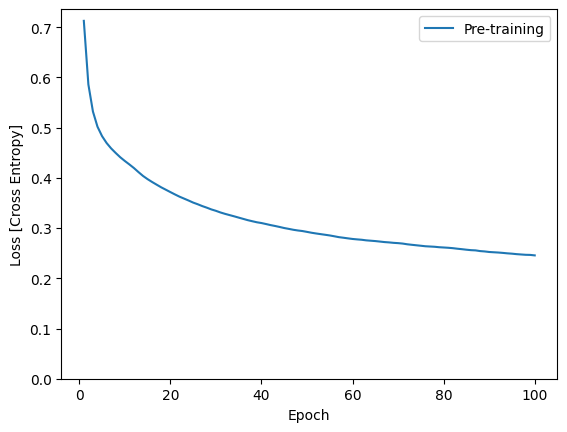

In [9]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

In [10]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [11]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

In [12]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

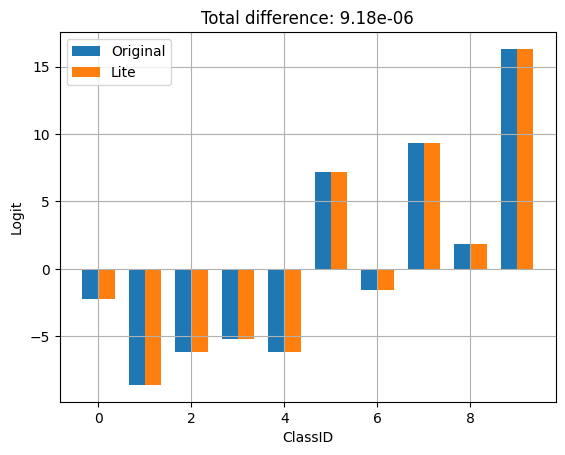

In [13]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

In [ ]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])


for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

In [ ]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

In [ ]:
logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})